# Result analysis of the web crawler

In this notebook, the dataframe filled with the cookies that were scraped using the webcrawler is analysed to gather what kind of information is saved by webpages upon arrival and after accepting the cookies. 


### Importing packages and the dataframe

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import ast
import urllib.request
import requests
import re

df = pd.read_csv('assets/DataFrame.csv', converters={"Host": ast.literal_eval,
                                                     "cookie_first": ast.literal_eval,
                                                     "cookie_second": ast.literal_eval
                                                     })

### Some statistics about the amount of websites

{'arrival': 7350, 'accepted': 3436, 'both': 3123}
313


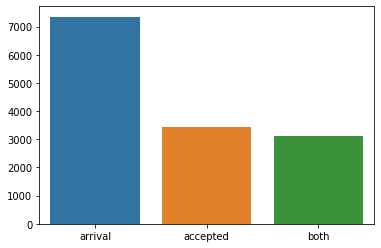

In [2]:
count = {'arrival': 0, 'accepted': 0, 'both': 0}

for index, row in df.iterrows():
    if (len(row['cookie_first']) > 0) & (len(row['cookie_second']) > 0):
        count['both'] += 1
    if len(row['cookie_first']) > 0:
        count['arrival'] += 1
    if len(row['cookie_second']) > 0:
        count['accepted'] += 1

sns.barplot(x=list(count.keys()), y=list(count.values()))
print(count)
print(count['accepted']-count['both'])


So far we see that **7350** websites created a cookie upon visiting, for **3436** websites, the crawler found a website and was able to accept the cookies, and lastly for **3123** websites both cookies were saved. This means that **313** websites that did save after confirmation did not make a cookie at first.


### Visiting cookie analysis

In [3]:
# Some functions that help to explore the list of cookies fast
def print_cookies(this_df):
    for index, row in this_df.iterrows():
        cookie = row['cookie_first'][0]
        print(row['Website'])
        for key, value in cookie.items():
            print(key, '=', value)
        print('')
        
def get_names(this_df, c):
    unique_names = []

    for index, row in this_df.iterrows():
        if c == 1:
            cookie = row['cookie_first'][0]
        if c == 2:
            cookie = row['cookie_second'][0]
        for key, value in cookie.items():
            if key == 'name':
                if value not in unique_names:
                    unique_names.append(value)
    return unique_names

In [4]:
a_df = df[df['cookie_first'].apply(lambda x: len(x) > 0)]

# print_cookies(a_df)

In [5]:
names = get_names(a_df, 1)
print("Found {} unique cookie names".format(len(names)))

Found 2991 unique cookie names


So now we have an overview of the cookies and their 'unique' names. Let's see if we can filter out some keywords like _'gtag', 'session', 'geo', 'fbp', 'id', 'gdpr', 'consent'_

In [6]:
key_words = {
    'gtag': [], # Google Tag
    'gat': [], # Google Analytics
    '_ga': [], # Google Analytics
    'gtm': [], # Google Tag Manager
    '__auc': [], # Targeting/Advertising 
    'session': [], 
    'geo': [], # Location
    'fbp': [], # Facebook Pixel
    'id': [], # Identifier
    'gdpr': [], 
    'consent': [], 
    'cookie': []
}


no_id = []
for index, row in a_df.iterrows():
    cookie = row['cookie_first'][0]
    for key, value in cookie.items():
        if key == 'name':
            found = False
            for word in key_words.keys():
                if word in value.lower():
                    key_words[word].append(cookie)
                    found = True
                    continue
            if not found:
                no_id.append(value.lower())

no_count = {}
for name in no_id:
    if name in no_count.keys():
        no_count[name] += 1
    else:
        no_count[name] = 1
                
# Print the counts
for key, value in key_words.items():
    print(key, ':', len(key_words[key]))
    
no_count = {k: v for k, v in sorted(no_count.items(), key=lambda item: item[1], reverse=True)}
print(len(no_count))

gtag : 47
gat : 304
_ga : 362
gtm : 23
__auc : 42
session : 465
geo : 57
fbp : 445
id : 2262
gdpr : 18
consent : 146
cookie : 142
1953


In [7]:
def get_cookie_stats(url):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,} 
    try:
        request=urllib.request.Request(url,None,headers)
        response = urllib.request.urlopen(request)
        data = str(response.read())
        if "no matches" in data:
            return False
        elif "not yet any general information" in data:
            return False
        else:
            return data  
    except Exception as e:
        return False
        print(e)

In [8]:
cookie_stats = pd.DataFrame(columns=['name', 
                                     'use', 
                                     'websites', 
                                     'hosts', 
                                     'first_party', 
                                     'third_party', 
                                     'persistent', 
                                     'life_span', 
                                     'session'])

In [9]:
error_count = 0

for name in tqdm(no_count.keys()):
    if name not in list(cookie_stats['name']):
#         print(name, end=': ')
        url = 'https://cookiepedia.co.uk/cookies/' + name
        
        data = get_cookie_stats(url)
        
        if data == False:
            error_count += 1
            continue
            
        ps = re.split('<p>|</p>', data)
        matching = [p for p in ps if 'main purpose' in p]
        usage = re.split('<strong>|</strong>', matching[0])[1]

        stats = re.split('<div class="cookie-stats">|</div>', data)[8]
        stats = re.split('<span>|</span>', stats)

        c_s = []
        if len(stats) > 13:
            c_s.append(name)
            c_s.append(usage)
            c_s.append(stats[1]) 
            c_s.append(stats[3])
            c_s.append(stats[5])
            c_s.append(stats[7])
            c_s.append(stats[9])
            c_s.append(stats[11])
            c_s.append(stats[13])
            cookie_stats.loc[len(cookie_stats)] = c_s
        else:
            print("not enough", name)
            
            
#         print(usage)

In [10]:
cookie_stats['use'].unique()

array(['Functionality', 'Targeting/Advertising', 'Performance',
       'Strictly Necessary', 'Unknown'], dtype=object)

In [11]:
cookie_stats

,name,use,websites,hosts,first_party,third_party,persistent,life_span,session
0,has_js,Functionality,"7,730","8,143","8,435",956,409,"262,816","8,982"
1,1p_jar,Targeting/Advertising,"3,310","1,446",68,"6,601","6,663","1,677,745",6
2,awsalbcors,Targeting/Advertising,"40,064","50,997","218,862","86,282","211,733","262,993","93,411"
3,___utmvc,Functionality,"3,535","3,419","3,450",648,"4,098","2,914,860",0
4,s_cc,Performance,"13,473","9,131","15,076","3,631","3,650","2,878,638","15,057"
...,...,...,...,...,...,...,...,...,...
258,_pk_ses.1.0c97,Performance,"4,352","4,559","4,516","1,425","5,881","506,909",60
259,cart_sig,Strictly Necessary,"1,443","1,430","1,419",90,"1,509","4,000",0
260,dwanonymous_56950516ebe71588e907d744842ca90b,Targeting/Advertising,"1,001",999,"1,095",232,"1,323","52,264",4
261,as,Targeting/Advertising,326,62,41,306,172,"500,003",175


### Accepted cookies

In [31]:
b_df = df[df['cookie_second'].apply(lambda x: len(x) > 0)]
b_df = b_df[b_df['cookie_second'] != {'cookie': None}]
second_names = get_names(b_df, 2)
second_names = [n.lower() for n in second_names]
second_names

['_js_datr',
 'csm-hit',
 'eu_cookie_v2',
 'ig_cb',
 'amcv_14215e3d5995c57c0a495c55%40adobeorg',
 'ds2',
 'hasseencookiedisclosure',
 'twdc-dtci_ensighten_privacy_twdc_vendor_consent',
 'mscc',
 'fg_9d12f2b2865de2f8c67706feaa332230',
 '_cmpqcif3pcsupported',
 'srchhpgusr',
 'optanonconsent',
 'tcs',
 'ts01ddf986',
 'tracking-opt-in-status',
 'eucookiebanner',
 '__lotl',
 'iter_id',
 '__auc',
 '_gid',
 'remixjsp',
 '_ga',
 '_cs_s',
 '_gat_www',
 'yc',
 '_tq_id.tv-81453654-1.edd5',
 'notice_gdpr_prefs',
 'ts01e3f36f',
 'cmrs',
 '_gat_gtag_ua_107148943_1',
 '_fbp',
 'thumbloadstats_vthumbs',
 'ms0',
 '_gat',
 'agreeterms',
 'sensitive_pixel_option',
 'sp_tpc',
 's_pers',
 'cookie_consent',
 'se-consent',
 's_ptc',
 '__cfruid',
 'kampyleuserpercentile',
 'atuserid',
 'pwinteraction',
 'ffsession',
 '_vice_cmp_modal_viewed',
 '_gw',
 'ccpa',
 'awsalbcors',
 '_bs',
 '___c3',
 'isg',
 '__gads',
 'adrizer_widget',
 's_sess',
 'rbximagecache',
 'userinfo',
 'c',
 'flags',
 '_awl',
 'dtcookie',


In [40]:
patterns = {}
for name in second_names:
    split = name.split('_')
    if len(split) > 1:
        p = split[0]
        i = 0
        while p == '':
            i += 1
            p = split[i]
    else:
        p = name
    if p not in patterns.keys():
        patterns[p] = 1
    else:
        patterns[p] += 1
        
patterns = {k: v for k, v in sorted(patterns.items(), key=lambda item: item[1], reverse=True)}
common_names = [k for k,v in patterns.items() if v > 5]
common_names

['amcv',
 'gat',
 'cookie',
 's',
 'sp',
 'gdpr',
 'pk',
 'incap',
 'user',
 'bcvm',
 'visitor',
 'cookieconsent',
 'privacy',
 'ga',
 'cookies',
 'sub',
 'gig']

In [42]:
cookie_stats_2 = pd.DataFrame(columns=['name', 
                                     'use', 
                                     'websites', 
                                     'hosts', 
                                     'first_party', 
                                     'third_party', 
                                     'persistent', 
                                     'life_span', 
                                     'session'])

In [48]:
s_df = df[df['click_found'] == True]
error_count_2 = 0

for i in tqdm(range(len(s_df))):
    row = s_df.iloc[i]
    cookie = row['cookie_second']
    
    if len(cookie) == 0:
        continue
    else:
        cookie = cookie[0]
        name = cookie['name']
        
        for cn in common_names:
            if name in cn:
                    name = cn
        
        if name in list(cookie_stats_2['name']):
            continue
        
        url = 'https://cookiepedia.co.uk/cookies/' + name
        
        data = get_cookie_stats(url)
        
        if data == False:
            error_count_2 += 1
            continue
            
        ps = re.split('<p>|</p>', data)
        matching = [p for p in ps if 'main purpose' in p]
        usage = re.split('<strong>|</strong>', matching[0])[1]

        if "cookie-stats" not in data:
            continue
            
        stats = re.split('<div class="cookie-stats">|</div>', data)[8]
        stats = re.split('<span>|</span>', stats)
        
        for index in range(1,14,2):
            try:
                stats[index] = int(stats[index].replace(',', ''))
            except ValueError:
                print(name)
                continue

        c_s = []
        if len(stats) > 13:
            c_s.append(name)
            c_s.append(usage)
            c_s.append(int(stats[1])) 
            c_s.append(int(stats[3]))
            c_s.append(int(stats[5]))
            c_s.append(int(stats[7]))
            c_s.append(int(stats[9]))
            c_s.append(int(stats[11]))
            c_s.append(int(stats[13]))
            cookie_stats_2.loc[len(cookie_stats_2)] = c_s
        else:
            print("not enough", name)

In [46]:
cookie_stats_2

,name,use,websites,hosts,first_party,third_party,persistent,life_span,session
0,_js_datr,Functionality,37,3,15,33,45,1018494,3
1,AMCV_14215E3D5995C57C0A495C55%40AdobeOrg,Targeting/Advertising,3696,2807,3693,487,4165,30155,15
2,OptanonConsent,Strictly Necessary,31357,28240,39175,14835,49635,3083,4375
3,__lotl,Targeting/Advertising,174,163,173,3,176,172,0
4,__auc,Targeting/Advertising,1763,460,503,1392,1895,2078,0
...,...,...,...,...,...,...,...,...,...
132,SC_ANALYTICS_GLOBAL_COOKIE,Performance,2360,2202,2377,382,2758,181505,1
133,AMCV_70D658CC558978FF7F000101%40AdobeOrg,Targeting/Advertising,3696,2807,3693,487,4165,30155,15
134,_sp_v1_data,Functionality,1945,1988,2302,1164,3137,58651,329
135,_gd_session,Functionality,1665,1310,69773,688,954,183080,69507


In [44]:
for index in range(1,14,2):
    print(index)

1
3
5
7
9
11
13


In [47]:
df.columns

Index(['Website', 'Host', 'cookie_first', 'Host checked', 'click_found',
       'cookie_second'],
      dtype='object')